In [2]:
import sys

sys.path.append(r'C:\Users\jerry\Desktop\Research\Kosuri\Rotor_Data_Interpretation\Jerry_Time_to_shine\DORA_Visualization-main\OMMxDORA-main\OMMxDORA-main\sma') #if you are not amanda, change to your sma file path (found in zipfile downloaded from github)


import DORA
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import math
import itertools
import seaborn as sns


In [8]:

exp_title = "Orbit Biotin 500Hz"
analysisName='Null'

# file_name = csvnum   #Jerry Gets rid of old file title
file_name = '00035.csv'
pk = os.path.splitext(file_name)[0]


#universal parameters
exp_tag = exp_title + pk # a tag that caries the name of the experiment


pixel_size = 117  # in nanometers
time_step = 2  # miliseconds per frame in trajectory movie
frame_start = 1000  # enter 0 to start from beginning of dataset
frame_end = 1499
# frame_start = 3500  # enter 0 to start from beginning of dataset
# frame_end = 4000
 # enter -1 to end at the last value of the data set
cmap = "spring_r" # enter a color map string from this https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
first_zero_end = 'no'  # yes to cut off all values after first 0,0 = x,y
graph_centers = "yes" #'yes' or 'no' to graphing the centers of the data. 
save_plot = 'yes' 

#downsampling parameters
bin_size = 20  # bin size for downsample/filter processing
processing = "none"  # enter downsample, moving average, or none

#Plot Parameters

#Which Graph?
plot_type = "2D"
#plot_type = "2D"
#Graphing options:
    #Trajectory Maps:
        #2D: Colorful 2D visulization of the rotor from above
        #3D: 2D plot but time is an axis
        #2D_LocPres: 2D plot now with Localization precision
    
    # Grid plot
        #grid: a grid of little snippets of the data
        
    #Angular Analysis
        #By Jerry
                #radius_filter: Demarcate the erroneous data points that will be eliminated from calculations
                #find_err_angle: Indicate erroneous angles within angular_continuous by Jerry
                #angular_continuous_filtered: Angular Continuous recalculated with erroneous points filtered. Questionable skips indicated.
                #basal3: Graphs tailored for the basal graph analysis 3/14/2022
                    #Angular Continuous with a downsampled curve as well. still has bugs with error labelling

    #Animation
        #interactive: Interactive graph
        #animated: animated trajectory in notebook
        #HTML: Animated trajectory in a new window. May run better

    ############################### these have not been converted yet:
        #By Claire:
                #angular: angle vs time, but it's not cummulative and resets at 360 to 0 (Claire)
                #angular_continuous: Claire's Calculation of a cummulative angle
                #find_err_angle_CR: Indicate erroneous angles within angular_continuous by Claire's calculations

    

##### Trajectory Maps Parameters:

# "yes" enables center display of center coordinates if 2D or Find err angle
display_center = "no"

#Labels
x_axis_label = "x (nm)"
y_axis_label = "y (nm)"
z_axis_label = "Time (ms)"  
unit = "nm"  # enter pixel or nm

#Formatting parameters
pixel_min = -0.75  # setting min/max axis range (pixel)
pixel_max = 0.75

# change axis increments for nicely fitting tick marks (pixel)
axis_increment_pixel = 7
# change axis increments for nicely fitting tick marks (nm)
axis_increment_nm = 7
nm_min = -150  # setting min/max axis range (nm)
nm_max = 150
#Do you want to save your plot?
save_plot = 'no'

#########Angle Versus Time (AVT or avt) Graphs

#       Formatting parameters for 'radius filter plot'
rad_filter_type_lower = 'nm'  # enter 'zscore' or 'nm' for choice
rad_filter_type_upper = 'zscore'  # enter 'zscore' or 'nm' for choice
z_up = 3  # enter an upper bound for z score.
z_down = -3  # enter a lower bound for z score
dist_low = 30  # lower bound for ABS of Radius filter
dist_high = 70  # upper bound for ABS of Radius filter

#       Formatting parameters for 'angular_continuous_filtered' plot
# enter 'line' or 'scatter' for a line graph or a scatter plot. Line plot makes up points when hovered
graph_style = 'line'


#Formatting parameters 'grid' plot
frames_per_plot = 500  # refers to grid plot
columns = 7  # columns of plots (grid plot)
fig_size_x = 40 # adjust display parameters for graphs to fit nicely, mostly used for 'grid' plot
fig_size_y  = 40 # adjust display parameters for graphs to fit nicely, mostly used for 'grid' plot

#Formatting parameters 'animation' plot
frame_speed = 20  # for animation only (ms)
tail_length = 50  # for animation only

#DORA.table parameters: 
save_table = 'no' #saves filtered table if "yes"

#DORA.Caldera parameters:
donut_width = 15

#DORA.collect_variable parameter package
###DataTable = avt_good cannot have bc it has not been defined yet
col = "Delta Angle"
sample_conditions= analysisName
name_saving_folder = "Data Tables"

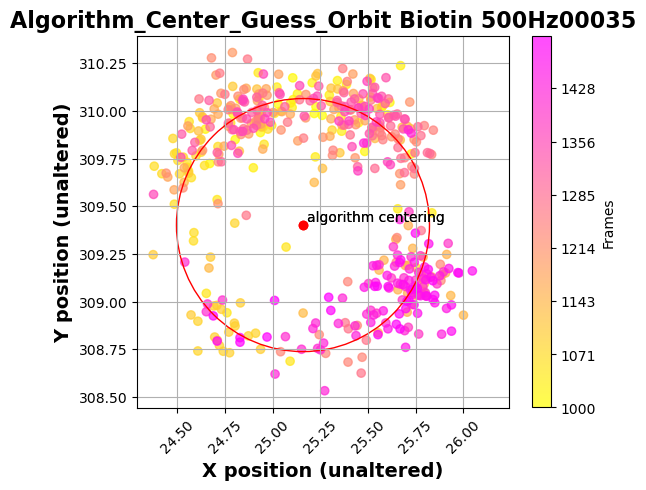

The center is (25.159478207023778, 309.4009729502152)
If the center is satisfactory, change the find_center_coordinates parameter to no
If the center is unsatisfactory, adjust the frame_start and frame_end parameters and try again


In [4]:
initial_parameters = [file_name, time_step, frame_start, frame_end, cmap, exp_tag, first_zero_end, graph_centers,save_plot]
center, data, ind_invalid_reading, data_back, my_rad_estimate = DORA.find_center(*initial_parameters)

In [5]:
downsample_parameters = [bin_size, processing, data, center, time_step, pixel_size, frame_start, frame_end]
down_sampled_df = DORA.downsample(*downsample_parameters)

In [6]:
locPre_type = "calculated" # "calculated" or "hand" or "stationary"
ring_width = 31 # width of donut in nm
if locPre_type == "hand":
    locPre_agg = ring_width
if locPre_type == "calculated":
    locPre_agg = down_sampled_df["Radius (nm)"].std() #Harvest the standard deviation of the radius
if locPre_type =="stationary":
    locPre_agg = down_sampled_df["Radius (nm)"].mean()


print(locPre_agg)
down_sampled_df["Radius (nm)"].std()

#calculate k constant based off of aggregated sigma or donut width and average intensity

#Calculate Average Intensity
I = down_sampled_df["Intensity"]
I_avg = I.mean() #Select stand still range
I_avg =490.0941883767535

#Calculate K based off of relation sigma = k * 1/sqrt(I)
k = locPre_agg * np.sqrt(I_avg)

#Use k value to recalculate every individual localization precision
down_sampled_df["Localization Precsion"] = k * (1 / np.sqrt(down_sampled_df["Intensity"]))



13.578999289174932


In [ ]:
plot_type = '
#Graph Groupings:
# create a list of the acceptable groupings for the trajectory maps
trajectory_map = ["2D", "3D"]

# create a list of the acceptable groupings for the Angle Time grouping
AngleTime = ["radius_filter", "find_err_angle", "angular_continuous_filtered",
                "basal3", "angular", "angular_continuous", "find_err_angle_CR"]

# create a list of the acceptable groupings for the Animations Grouping

animations = ["interactive", "animated", "HTML"]




#Trajectory map parameters:
tajectory_map_parameters = [file_name, down_sampled_df, plot_type, display_center, exp_tag, x_axis_label, y_axis_label, z_axis_label, unit, 
pixel_min, pixel_max, axis_increment_nm, axis_increment_pixel, nm_min, nm_max, save_plot, frame_start, frame_end, time_step,cmap,exp_tag]

#Angle Versus Time (AVT or avt) parameters:
avt_parameters = [file_name, down_sampled_df, plot_type, display_center, ind_invalid_reading, rad_filter_type_upper,
                  rad_filter_type_lower, z_up, z_down, dist_high, dist_low, graph_style, bin_size, frame_start, frame_end,
                  display_center, exp_tag, x_axis_label, y_axis_label, z_axis_label, unit, pixel_min, pixel_max,
                  axis_increment_nm, axis_increment_pixel, nm_min, nm_max, save_plot, data_back, cmap, exp_tag] 

#Animated Parameters
animated_parameters = [file_name, down_sampled_df, plot_type, display_center, ind_invalid_reading, rad_filter_type_upper,
                  rad_filter_type_lower, z_up, z_down, dist_high, dist_low, graph_style, bin_size, frame_start, frame_end,
                  display_center, exp_tag, x_axis_label, y_axis_label, z_axis_label, unit, pixel_min, pixel_max,
                  axis_increment_nm, axis_increment_pixel, nm_min, nm_max, save_plot, data_back, cmap, exp_tag, frame_speed, tail_length] 

#Grid Parameters
grid_parameters = [file_name, down_sampled_df, plot_type, display_center, exp_tag, x_axis_label, y_axis_label, z_axis_label, unit, 
pixel_min, pixel_max, axis_increment_nm, axis_increment_pixel, nm_min, nm_max, save_plot, frame_start, frame_end, time_step,cmap,exp_tag, 
frames_per_plot, columns, fig_size_x, fig_size_y]


# #DORA.graph(plot_type,*relevant_parameters)

if plot_type == "2D" or plot_type == "3D":
    DORA.graph(plot_type,*tajectory_map_parameters)
if plot_type in animations:
    %matplotlib notebook
    DORA.graph(plot_type,*animated_parameters)
if plot_type == "grid":
    DORA.graph(plot_type, *grid_parameters)
if plot_type in AngleTime:
    DORA.graph(plot_type,*avt_parameters)

<IPython.core.display.Javascript object>

# Kernel generator everywhere


In [62]:
##ATtEMPT 2 

#collect relevant variables for gaussian collection
kerBoom = down_sampled_df[["index","X displacement (nm)","Y displacement (nm)","Localization Precsion"]].copy()
# kerBoom_small = kerBoom.iloc[0:100,:].copy() # take on the first 100 points for simplicity

#Matrix parameters
# mat_res = 1 #resolution of nm per box or grid increment
# mat_size = 150 # size of the nxn matrix that is the map (use only odd numbers so there is a 0,0 column)
# mat_bound = mat_res*mat_size
mat_res = 0.1 #resolution of nm per box or grid increment
# mat_size = 150 # size of the nxn matrix that is the map (use only odd numbers so there is a 0,0 column)
# mat_bound = 
mat_bound = 150 #bound of the matrix grid in nm 
mat_size = int(mat_bound/mat_res)


#establish the upper and lower bounds in nm
bound = mat_res * (mat_size-1)    # [(nm/box)*box = nm bound] # minus one is for the 0 column  
gov_x = np.arange(-bound,bound+mat_res*2,mat_res*2) #create the governing  x vector, 
gov_y = gov_x

#initialize the mapped matrix:
felt_xcoord_temp = np.zeros((mat_size,mat_size)) # x coordinates of where the waves of the gaussian are felt
felt_xcoord = felt_xcoord_temp + gov_x
felt_ycoord = felt_xcoord.T

def calc_gauss_kernel(x_c,y_c,felt_xcoord,felt_ycoord,sigma):
    A = 1/(2*math.pi*sigma**2) # find A coefficient
    diff = (felt_xcoord-x_c)**2 + (felt_ycoord-y_c)**2 # calculate exponent pt1 
    exponent = -1/(2*sigma**2) * diff # calculate exponent pt2 
    kernel = A*np.exp(exponent) # combine parts of eq
    return kernel

#initialize input matrix:
mat_base=np.zeros((mat_size,mat_size))
counter = 0 


for k in range(kerBoom.shape[0]):
    #section the k th row of the matrix and assign variables
    #x_c bc this the x center of the gaussian and likewise for y_c
    [x_c, y_c, sigma] = kerBoom.iloc[k,[1,2,3]].copy()
    my_kernel = calc_gauss_kernel(x_c,y_c,felt_xcoord,felt_ycoord,sigma)
    mat_base = mat_base + my_kernel
    counter = counter ++1 

print(mat_base)
print (mat_base.max)



# #Turn Matrix into dataframe to access pd functions
# mat_df = pd.DataFrame(mat_base)
# heat_map_table = mat_df.stack().reset_index()
# heat_map_table.columns = ["X (nm)", "Y (nm)", "Probability"]

# x = heat_map_table.iloc[:,[0]]
# y = heat_map_table.iloc[:,[1]]
# Z = heat_map_table.iloc[:,[2]] 
# print(heat_map_table)
# print(Z)

# #Figure Settings
# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

# fig = plt.figure()



# ax = fig.add_subplot(111)

# X, Y = np.meshgrid(x, y)

# cp = ax.contour(X, Y, Z)



# ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap="plasma", linewidth=0, antialiased=False)

# plt.show()





#make axes labels 


# plt.xticks(mat_base, ['-2π', '-3π/2', 'π', '-π/2', '0', 'π/2', 'π', '3π/2', '2π'])





# fig, ax = plt.subplots()

# fig.imshow(mat_base)

# ax.set_xticks(gov_x)
# ax.set_xticklabels(('$a$', '$valx$', '$b$'))

#Turn Matrix into dataframe to access pd functions
# mat_df = pd.DataFrame(mat_base)
# heat_map_table = mat_df.stack().reset_index()
# heat_map_table.columns = ["X (nm)", "Y (nm)", "Probability"]

# X = heat_map_table.iloc[:,[0]]
# Y = heat_map_table.iloc[:,[1]]
# Z = heat_map_table.iloc[:,[2]] 
# print(heat_map_table)
# print(heat_map_table)

# # Create a surface plot and projected filled contour plot under it.
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True,
#                 cmap=cm.viridis)

# cset = ax.contourf(X, Y, Z, zdir='z', offset=-0.15, cmap=cm.viridis)

# # Adjust the limits, ticks and view angle
# ax.set_zlim(-0.15,0.2)
# ax.set_zticks(np.linspace(0,0.2,5))
# ax.view_init(27, -21)

# plt.show()

    


[[2.24571737e-32 2.64731321e-32 3.11967422e-32 ... 1.14586453e-22
  1.04012867e-22 9.43837164e-23]
 [2.56570635e-32 3.02453110e-32 3.56420665e-32 ... 1.31841079e-22
  1.19675305e-22 1.08596181e-22]
 [2.93030364e-32 3.45433645e-32 4.07071210e-32 ... 1.51643724e-22
  1.37650642e-22 1.24907424e-22]
 ...
 [1.25652428e-26 1.50619396e-26 1.80477980e-26 ... 8.72493509e-26
  7.34800916e-26 6.18601391e-26]
 [1.14834476e-26 1.37651656e-26 1.64939211e-26 ... 7.90173608e-26
  6.65472332e-26 5.60236249e-26]
 [1.04909532e-26 1.25754404e-26 1.50683190e-26 ... 7.15346663e-26
  6.02454203e-26 5.07183644e-26]]
<built-in method max of numpy.ndarray object at 0x000001ED8FE2AE10>


C:\Users\jerry\AppData\Local\Temp/ipykernel_21952/3705171908.py:31: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(fig, label=z_axis_label, shrink=.82)


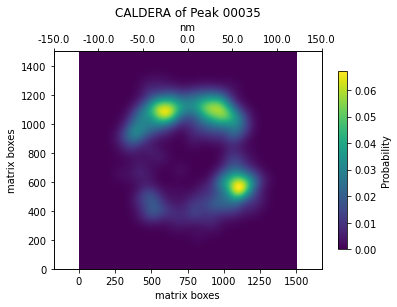

In [63]:
n_rows = mat_base.shape[0]
ax1 = plt.subplot(1, 1,1)
fig = plt.imshow(mat_base)
plt.axis('on')
ax1.set(xlim=(0, n_rows), ylim=(0, n_rows+1))

ax_x2 = ax1.twiny()
# ax_y2 = ax1.twinx()

# Graph settings 

ax1.set_xlabel('matrix boxes')
ax1.set_ylabel('matrix boxes')
ax_x2.set_xlabel('nm')
ax_x2.set_ylabel('nm')

tiks = np.linspace(-mat_bound,mat_bound,7)
tk = pd.DataFrame(tiks)
# ax1.set_xticklabels(tiks)


ax_x2.set_xticks(tk.index)
ax_x2.set_xticklabels(list(tk[0]))
# ax_x2.set_yticks(tk.index)
# ax_x2.set_yticklabels(list(tk[0]))
plt.title("CALDERA of Peak 00035")



z_axis_label = "Probability"
plt.colorbar(fig, label=z_axis_label, shrink=.82)

In [68]:
#section the k th row of the matrix and assign variables
k = 1 # kth index
[x_c, y_c, sigma] = kerBoom_small.iloc[k,[1,2,3]].copy() #x_c bc this the x center of the gaussian and likewise for y_c






In [ ]:
kerBoom_small[]


maty = np.zeros(9) + 2
mati = np.reshape(maty, [3,3])

np.sqrt(mati+mati)


[Text(0.5, 1.0, 'KDE_Exp 9 - 5uM on - Peak RecBCD_LocPre')]

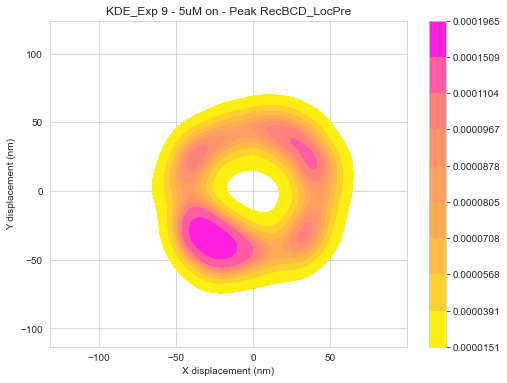

In [39]:
# Claire's code accepts down_sampled_df as df
df = down_sampled_df

#####################Graphing data assignment block##############
# Here the code determines the units of the graph, only for cartesian graphs
if unit == "pixel":
    x = df["X displacement (pixels)"]
    y = df["Y displacement (pixels)"]
if unit == "nm":
    x = df["X displacement (nm)"]
    y = df["Y displacement (nm)"]
z = df["Time (ms)"]
    


# assign values of x y and z
# move this outside this block to apply for all "none"

#Graph KDE uninformed Gausian: 

#Setup Graph Settings

#Define graph size
plt.figure(figsize=(8,6))
#Let there be a Grid
sns.set_style('whitegrid')

# plot title and font configurations
# take the file name and separate from the extension
# the first value in the tuple is the number
# the second is .csv 
# the number 00086.csv is the peak --> so this code takes the peak number
pk = os.path.splitext(file_name)[0]

graph_type = "KDE"

# change title order!!! 
list_of_strings = [graph_type, exp_tag]

#in quotes is the the delimiter between the items in the string
# by default it is a _ 
my_title = "_".join(list_of_strings)


sns.kdeplot( x = x, y = y, n_levels = 10, shade = True, cbar = True, cmap="spring_r",).set(title=my_title)
# sns.rugplot( x = x, y = y)





In [53]:
df = down_sampled_df
df

,index,X position,Y position,Intensity,X displacement (pixels),Y displacement (pixels),X displacement (nm),Y displacement (nm),Time (ms),Radius (nm),z-score Rad,Angle,Localization Precsion
1000,1000,25.577585,310.027313,1055.0,0.418107,0.626340,48.918521,73.281813,2000,88.109283,0.773649,303.724684,12.910653
1001,1001,25.603613,309.979218,1080.0,0.444135,0.578245,51.963759,67.654616,2002,85.307557,0.567114,307.526934,12.760349
1002,1002,25.260376,309.976501,939.0,0.100898,0.575529,11.805039,67.336836,2004,68.363795,-0.681930,279.943659,13.684900
1003,1003,25.451231,309.937592,1029.0,0.291753,0.536619,34.135077,62.784376,2006,71.463847,-0.453403,298.532370,13.072744
1004,1004,25.513226,310.072571,879.0,0.353747,0.671598,41.388440,78.576949,2008,88.810696,0.825355,297.776896,14.144252
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1494,1494,24.970936,308.814087,1057.0,-0.188542,-0.586886,-22.059459,-68.665666,2988,72.122073,-0.404881,107.810079,12.898433
1495,1495,24.829224,308.786926,955.0,-0.330255,-0.614047,-38.639785,-71.843462,2990,81.575217,0.291977,118.272831,13.569778
1496,1496,24.689177,308.924866,845.0,-0.470302,-0.476107,-55.025293,-55.704546,2992,78.299293,0.050486,134.648533,14.426005
1497,1497,25.010557,309.005859,916.0,-0.148921,-0.395114,-17.423761,-46.228288,2994,49.402855,-2.079674,110.651772,13.855643


In [32]:
center_overide = [25.4, 310.1]

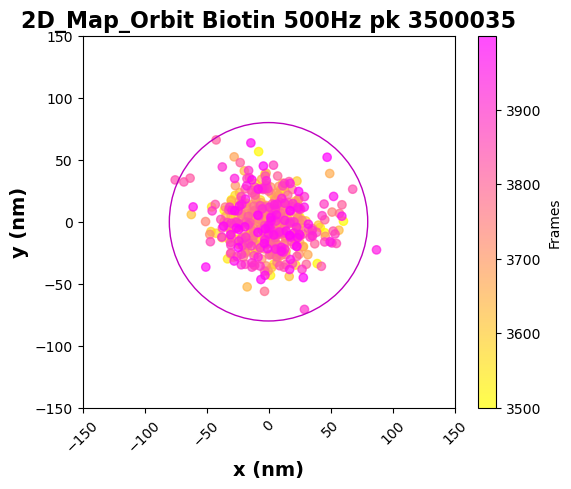

In [33]:
center = center_overide 
downsample_parameters = [bin_size, processing, data, center, time_step, pixel_size, frame_start, frame_end]
down_sampled_df = DORA.downsample(*downsample_parameters)
#Graph Groupings:
# create a list of the acceptable groupings for the trajectory maps
trajectory_map = ["2D", "3D"]

# create a list of the acceptable groupings for the Angle Time grouping
AngleTime = ["radius_filter", "find_err_angle", "angular_continuous_filtered",
                "basal3", "angular", "angular_continuous", "find_err_angle_CR"]

# create a list of the acceptable groupings for the Animations Grouping

animations = ["interactive", "animated", "HTML"]

#Trajectory map parameters:
tajectory_map_parameters = [file_name, down_sampled_df, plot_type, display_center, exp_tag, x_axis_label, y_axis_label, z_axis_label, unit, 
pixel_min, pixel_max, axis_increment_nm, axis_increment_pixel, nm_min, nm_max, save_plot, frame_start, frame_end, time_step,cmap,exp_tag]

#Angle Versus Time (AVT or avt) parameters:
avt_parameters = [file_name, down_sampled_df, plot_type, display_center, ind_invalid_reading, rad_filter_type_upper,
                  rad_filter_type_lower, z_up, z_down, dist_high, dist_low, graph_style, bin_size, frame_start, frame_end,
                  display_center, exp_tag, x_axis_label, y_axis_label, z_axis_label, unit, pixel_min, pixel_max,
                  axis_increment_nm, axis_increment_pixel, nm_min, nm_max, save_plot, data_back, cmap, exp_tag] 

#Animated Parameters
animated_parameters = [file_name, down_sampled_df, plot_type, display_center, ind_invalid_reading, rad_filter_type_upper,
                  rad_filter_type_lower, z_up, z_down, dist_high, dist_low, graph_style, bin_size, frame_start, frame_end,
                  display_center, exp_tag, x_axis_label, y_axis_label, z_axis_label, unit, pixel_min, pixel_max,
                  axis_increment_nm, axis_increment_pixel, nm_min, nm_max, save_plot, data_back, cmap, exp_tag, frame_speed, tail_length] 

#Grid Parameters
grid_parameters = [file_name, down_sampled_df, plot_type, display_center, exp_tag, x_axis_label, y_axis_label, z_axis_label, unit, 
pixel_min, pixel_max, axis_increment_nm, axis_increment_pixel, nm_min, nm_max, save_plot, frame_start, frame_end, time_step,cmap,exp_tag, 
frames_per_plot, columns, fig_size_x, fig_size_y]


# #DORA.graph(plot_type,*relevant_parameters)

if plot_type == "2D" or plot_type == "3D":
    DORA.graph(plot_type,*tajectory_map_parameters)
if plot_type in animations:
    %matplotlib notebook
    DORA.graph(plot_type,*animated_parameters)
if plot_type == "grid":
    DORA.graph(plot_type, *grid_parameters)
if plot_type in AngleTime:
    DORA.graph(plot_type,*avt_parameters)


In [48]:
locPre_agg = down_sampled_df["Radius (nm)"].mean()
#Calculate Average Intensity
I = down_sampled_df["Intensity"]
I_avg = I.mean() #Select stand still range

In [49]:
print(f"My Localization precision is: {locPre_agg}")
print(f"My Intensity at this place is: {I_avg}")

My Localization precision is: 77.61443591471327
My Intensity at this place is: 953.7034068136272


In [23]:
##ATtEMPT 3 

#collect relevant variables for gaussian collection
kerBoom = down_sampled_df[["index","X displacement (nm)","Y displacement (nm)","Localization Precsion"]].copy()
# kerBoom_small = kerBoom.iloc[0:100,:].copy() # take on the first 100 points for simplicity

#Matrix parameters
mat_res = 1 #resolution of nm per box or grid increment
mat_bound = 150 #bound of the matrix grid in nm 
mat_size = int(mat_bound/mat_res)


#establish the upper and lower bounds in nm
bound = mat_res * (mat_size-1)    # [(nm/box)*box = nm bound] # minus one is for the 0 column  
gov_x = np.arange(-bound,bound+mat_res*2,mat_res*2) #create the governing  x vector, 
gov_y = gov_x

#initialize the mapped matrix:
felt_xcoord_temp = np.zeros((mat_size,mat_size)) # x coordinates of where the waves of the gaussian are felt
felt_xcoord = felt_xcoord_temp + gov_x
felt_ycoord = felt_xcoord.T

def calc_gauss_kernel(x_c,y_c,felt_xcoord,felt_ycoord,sigma):
    A = 1/(2*math.pi*sigma**2) # find A coefficient
    diff = (felt_xcoord-x_c)**2 + (felt_ycoord-y_c)**2 # calculate exponent pt1 
    exponent = -1/(2*sigma**2) * diff # calculate exponent pt2 
    kernel = A*np.exp(exponent) # combine parts of eq
    return kernel

#initialize input matrix:
mat_base=np.zeros((mat_size,mat_size))
counter = 0 


for k in range(kerBoom.shape[0]):
    #section the k th row of the matrix and assign variables
    #x_c bc this the x center of the gaussian and likewise for y_c
    [x_c, y_c, sigma] = kerBoom.iloc[k,[1,2,3]].copy()
    my_kernel = calc_gauss_kernel(x_c,y_c,felt_xcoord,felt_ycoord,sigma)
    mat_base = mat_base + my_kernel
    counter = counter ++1 

print(mat_base)
print (mat_base.max)



# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(felt_xcoord, felt_ycoord, mat_base, cmap='plasma')
ax.set_zlim(0,np.max(Z)+2)
plt.show()


    


[[8.52964978e-32 4.28872235e-31 2.08516227e-30 ... 1.73842517e-21
  7.00769532e-22 2.73285172e-22]
 [3.13588304e-31 1.57727695e-30 7.67219478e-30 ... 6.86104090e-21
  2.76572825e-21 1.07857584e-21]
 [1.11488575e-30 5.61023997e-30 2.73061665e-29 ... 2.61966833e-20
  1.05600546e-20 4.11820295e-21]
 ...
 [1.94776953e-25 1.15275483e-24 6.56477987e-24 ... 3.15911631e-23
  6.07535233e-24 1.12447357e-24]
 [8.45988202e-26 5.00642692e-25 2.85094506e-24 ... 1.25631661e-23
  2.41604357e-24 4.47179914e-25]
 [3.54089391e-26 2.09518886e-25 1.19302261e-24 ... 4.80844650e-24
  9.24720210e-25 1.71154273e-25]]
<built-in method max of numpy.ndarray object at 0x0000028D21D566F0>


<IPython.core.display.Javascript object>

In [20]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# The two-dimensional domain of the fit.
xmin, xmax, nx = -5, 4, 75
ymin, ymax, ny = -3, 7, 150
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)
print(x.shape,y.shape)

# Our function to fit is going to be a sum of two-dimensional Gaussians
def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

# A list of the Gaussian parameters: x0, y0, xalpha, yalpha, A
gprms = [(0, 2, 2.5, 5.4, 1.5),
         (-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         (3, 0.5, 2, 1, 5)
        ]

# Standard deviation of normally-distributed noise to add in generating
# our test function to fit.
noise_sigma = 0.1

# The function to be fit is Z.
Z = np.zeros(X.shape)
for p in gprms:
    Z += gaussian(X, Y, *p)
Z += noise_sigma * np.random.randn(*Z.shape)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
ax.set_zlim(0,np.max(Z)+2)
plt.show()

(75,) (150,)


<IPython.core.display.Javascript object>